# Clasificación de cactus de la reserva de la biósfera
## Variante: MobileNet

Proyecto 9 - Asistencia al monitoreo ambiental
Proyectos de investigación en Inteligencia Artificial en el Espacio de Innovación UNAM – HUAWEI

En este notebook se lleva a cabo el diseño de experimento planteado.

Conjunto de datos: López-Jiménez, E., Vasquez-Gomez, J. I., Sanchez-Acevedo, M. A., Herrera-Lozada, J. C., & Uriarte-Arcia, A. V. (2019). Columnar cactus recognition in aerial images using a deep learning approach. Ecological Informatics, 52, 131-138.

## Implementación

### Dependencias

In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
#from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.applications.xception import Xception
#from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

## Preprocesamiento de imágenes

Se utiliza el aumentador de datos de Keras

In [3]:
augs_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)  

train_gen = augs_gen.flow_from_directory(
    '../input/training_set/training_set',
    target_size = (32,32),
    batch_size=32,
    shuffle=True,
    class_mode = 'binary'
)

test_gen = augs_gen.flow_from_directory(
    '../input/validation_set/validation_set/',
    target_size=(32,32),
    batch_size=32,
    shuffle=False,
    class_mode = 'binary'
)

Found 17500 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


# Modelo de red neuronal

Implementación de MobileNet V2 para la clasificación de cactus

In [4]:
from keras.applications.mobilenet import MobileNet

In [5]:
# create the base pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [6]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Entrenamiento


In [7]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [8]:
opt = SGD(lr=2e-4,momentum=0.99)
opt1 = Adam(lr=1e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    validation_data = test_gen,
    validation_steps = 100,
    steps_per_epoch  = 100, 
    epochs = 1,
    verbose = 1,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 18s 178ms/step - loss: 0.1909 - acc: 0.9328 - val_loss: 0.0751 - val_acc: 0.9809

Epoch 00001: val_loss improved from inf to 0.07510, saving model to ./base.model
Epoch 2/30
100/100 [==============================] - 13s 126ms/step - loss: 0.0988 - acc: 0.9600 - val_loss: 0.0751 - val_acc: 0.9725

Epoch 00002: val_loss did not improve from 0.07510
Epoch 3/30
100/100 [==============================] - 13s 135ms/step - loss: 0.1079 - acc: 0.9603 - val_loss: 0.0891 - val_acc: 0.9688

Epoch 00003: val_loss did not improve from 0.07510
Epoch 4/30
100/100 [==============================] - 13s 125ms/step - loss: 0.0909 - acc: 0.9712 - val_loss: 0.0856 - val_acc: 0.9669

Epoch 00004: val_loss did not improve from 0.07510
Epoch 5/30
100/100 [==============================] - 13s 134ms/step - loss: 0.0727 - acc: 0.9775 - val_loss: 0.2972 - val_acc: 0.9116

Epoch 00005: val_loss did not improve 

## Evaluación del modelo entrenado

Model Test Loss: 0.035154887272510676
Model Test Accuracy: 0.993125
Weights Saved


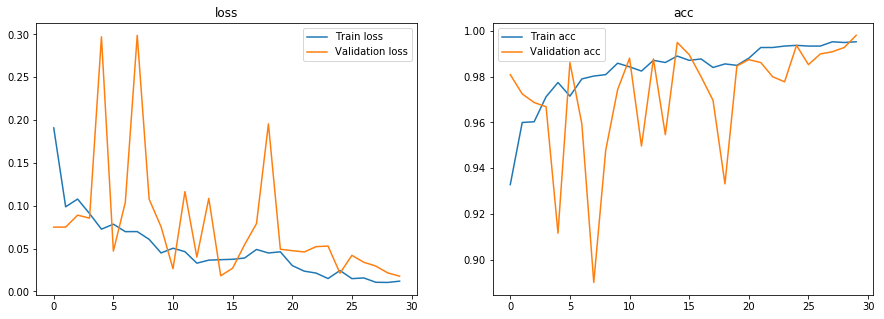

In [9]:
show_final_history(history)
plt.savefig('performance.eps', format='eps')

model.load_weights(best_model_weights)
model_eval = model.evaluate_generator(test_gen,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

## TensorBoard


In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2022-07-10 00:55:06--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
ERROR: The certificate of ‘bin.equinox.io’ is not trusted.
ERROR: The certificate of ‘bin.equinox.io’ has expired.
unzip:  cannot find or open ngrok-stable-linux-amd64.zip, ngrok-stable-linux-amd64.zip.zip or ngrok-stable-linux-amd64.zip.ZIP.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/opt/conda/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/opt/conda/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/opt/conda/lib/python3.6/json